In [1]:
import pandas as pd
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [ ]:
trainData = pd.read_csv('train.csv', nrows=10000000)
trainData.head()

## **1.Take a look at the training data. There may be anomalies in the data that you may need to factor in before you start on the other tasks. Clean the data first to handle these issues. Explain what you did to clean the data (in bulleted form)**

In [3]:
def clean_location_data(df):
    '''
    Consider locations within New York state. 
    According to http://www.netstate.com/states/geography/ny_geography.htm,
    Longitude: 71° 47' 25" W to 79° 45' 54" W
    Latitude: 40° 29' 40" N to 45° 0' 42" N
    
    West -74.257159 East -73.699215
    North 40.915568 South 40.495992
    '''
    df = df[(df['pickup_longitude'] >= -75.257159) & (df['pickup_longitude'] <= -71.699215)]
    df = df[(df['dropoff_longitude'] >= -75.257159) & (df['dropoff_longitude'] <= -71.699215)]
    df = df[(df['pickup_latitude'] >= 40.29) & (df['pickup_latitude'] <= 43.495992)]
    df = df[(df['dropoff_latitude'] >= 40.29) & (df['dropoff_latitude'] <= 43.495992)]
    
    return df

In [4]:
def clean_fare_data(df):
    '''
    The dataset consists of negative fare_amount. Consider fares between 0 to 300usd. 
    '''
    df = df[(0 < df['fare_amount']) & (df['fare_amount'] <= 300)]
    
    return df

In [5]:
def clean_pcount_data(df):
    '''
    The dataset consists of negative passenger_count. Consider passenger count between 0 to 6. 
    '''
    df = df[(df['passenger_count'] > 0) & (df['passenger_count'] <= 12)]
    
    return df

In [6]:
def clean_taxi_data(df):
    location_df = clean_location_data(df)
    fare_data = clean_fare_data(location_df)
    pc_data = clean_pcount_data(fare_data)
    
    pc_data = pc_data.dropna()
    return pc_data

In [7]:
trainData = clean_taxi_data(trainData)
trainData['fare_amount'].fillna((trainData['fare_amount'].mean()), inplace=True)

In [8]:
print(len(trainData))

9753468


## **2. Compute the Pearson correlation between the following: **

**a. Euclidean distance of the ride and the taxi fare**

In [11]:
def add_euclidean_dist(df):
  df['absLatDiff'] = (df['pickup_latitude'] - df['dropoff_latitude']).abs() 
  df['absLonDiff'] = (df['pickup_longitude'] - df['dropoff_longitude']).abs()

  df['euclidean'] = (df['absLatDiff'] ** 2 + df['absLonDiff'] ** 2) ** 0.5

In [12]:
add_euclidean_dist(trainData)

In [11]:
pearsonr(trainData.euclidean, trainData.fare_amount)

(0.8276757184089164, 0.0)

**b. time of day and distance traveled**

In [13]:
def add_datetime_feature(df):
  df['pickup_datetime'] =  pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S %Z')
  df['year'] = df['pickup_datetime'].apply(lambda x: x.year)
  df['month'] = df['pickup_datetime'].apply(lambda x: x.month)
  df['date'] = df['pickup_datetime'].apply(lambda x: x.day)
  df['hour'] = df['pickup_datetime'].apply(lambda x: x.hour)
  df['minute'] = df['pickup_datetime'].apply(lambda x: x.minute)
  df['day'] = df['pickup_datetime'].apply(lambda x: x.weekday())

In [14]:
add_datetime_feature(trainData)

In [14]:
pearsonr(trainData.euclidean, trainData.hour)

(-0.027815375901820063, 0.0)

**c. time of day and the taxi fare**

In [15]:
pearsonr(trainData.hour, trainData.fare_amount)

(-0.017140437554539145, 0.0)

### We got the highest pearson coefficient with Euclidean distance and fare_amount ###

## **3. For each subtask of (2), create a plot visualizing the relation between the variables. Comment on whether you see non-linear or any other interesting relations.**

**a.  Euclidean distance of the ride and the taxi fare** 

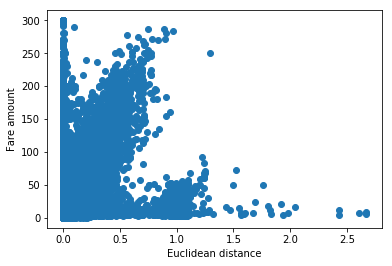

In [16]:
plt.scatter(trainData.euclidean, trainData.fare_amount)
plt.xlabel('Euclidean distance')
plt.ylabel('Fare amount')

**b. time of day and distance traveled**

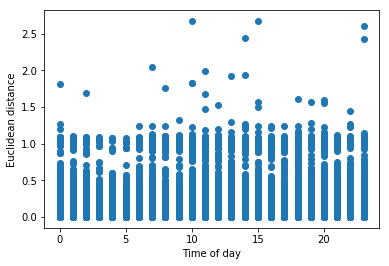

In [17]:
plt.scatter(trainData.hour, trainData.euclidean)
plt.xlabel('Time of day')
plt.ylabel('Euclidean distance')

**c. time of day and taxi fare**

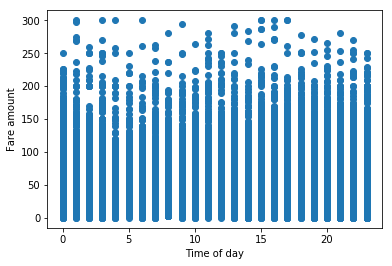

In [18]:
plt.scatter(trainData.hour, trainData.fare_amount)
plt.xlabel('Time of day')
plt.ylabel('Fare amount')

### We can observe a linear relation between euclidean distance and fare amount, and non-linear amongst other ###

## **4. Create an exciting plot of your own using the dataset that you think reveals something very interesting.   Explain what it is, and anything else you learned. **

**a. Distribution of fare_amount - We group the fare_amount from 0 to >60 usd , with bins of 5 usd**

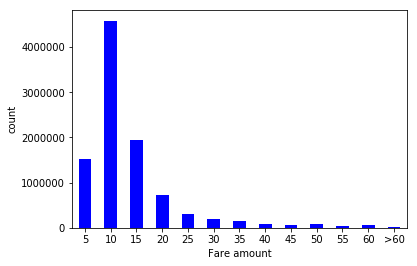

'\nWe observe that most trips have a fare_amount of $10-15\n'

In [19]:
bins = (0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, np.inf)
labels = ('5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55', '60', '>60')
groups = pd.cut(trainData.fare_amount, bins=bins, labels=labels)
groups.value_counts()
ax = groups.value_counts(sort=False).plot.bar(rot=0, color="b")
ax.set_xticklabels(labels)
plt.xlabel('Fare amount')
plt.ylabel('count')
plt.show()

'''
We observe that most trips have a fare_amount of $10-15
'''

**b. Distribution of passenger_count rides on each day of the week**

'\nThe plot shows distribution of passenger_count rides on each day of the week.\nWe plotted two line, based on single passenger ride and multiple passenger_count \nride across the day of the week. We notice that the single passenger rides drops down \nduring the weekend, while multiple passenger rides increases on Saturday. We can \ninfer that during weekends a lot of people go for family or friends outing.\n'

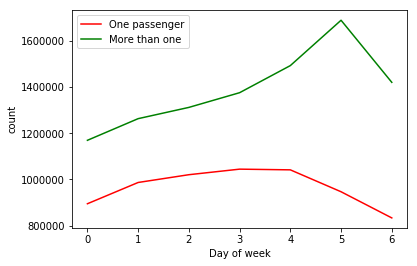

In [20]:
single_pc = []
multi_pc = []
days = []

for i in range(0, 7, 1):
  days.append(i)
  single_pc.append(trainData.loc[((trainData['day'] == i) & (trainData['passenger_count'] == 1)), 'passenger_count'].sum())
  multi_pc.append(trainData.loc[((trainData['day'] == i) & (trainData['passenger_count'] > 1)), 'passenger_count'].sum())
  
plt.plot(days, single_pc, c = 'red', label="One passenger")
plt.plot(days, multi_pc, c = 'green', label="More than one")
plt.xlabel('Day of week')
plt.ylabel('count')
plt.legend()

'''
The plot shows distribution of passenger_count rides on each day of the week.
We plotted two line, based on single passenger ride and multiple passenger_count 
ride across the day of the week. We notice that the single passenger rides drops down 
during the weekend, while multiple passenger rides increases on Saturday. We can 
infer that during weekends a lot of people go for family or friends outing.
'''

**c. Distribution of fare_amount in each month**

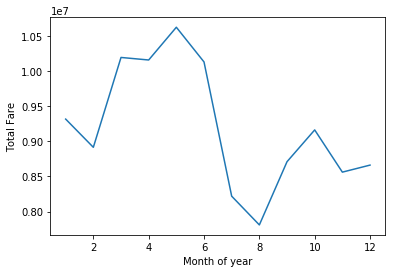

In [21]:
months = []
fare_per_month = []

for i in range(1, 13, 1):
    months.append(i)
    fare_per_month.append(trainData.loc[(trainData['month'] == i ), 'fare_amount'].sum())

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.plot(months, fare_per_month)
plt.xlabel('Month of year')
plt.ylabel('Total Fare')

# **5. Generate additional features like those from (2) from the given data set. What additional features can you create?**

In [15]:
def add_season_feature(df):
  '''
  We will group the months into season such that:
  Winter -> January, February, December -> 1
  Spring -> March, April, May -> 2
  Summer -> June, July, August -> 3
  Fall -> September, October, November -> 4
  '''
  df['season'] = df['pickup_datetime'].apply(lambda x: (x.month%12 + 3)//3)

In [16]:
add_season_feature(trainData)

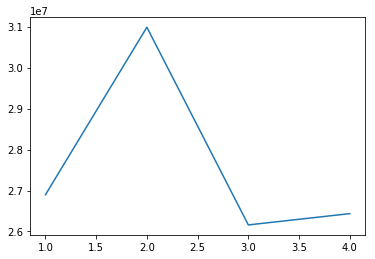

In [24]:
seasons = []
fare_per_season = []

for i in range(1, 5, 1):
    seasons.append(i)
    fare_per_season.append(trainData.loc[(trainData['season'] == i ), 'fare_amount'].sum())

plt.plot(seasons, fare_per_season)

##### We notice that fare_amount sum is highest during spring and lowest in summer. #####

In [26]:
def add_late_night(r):
  if((r.hour > 22) or (r.hour < 6)):
    return 1
  else:
    return 0
                                                 
trainData['late_night'] = trainData.apply(add_late_night, axis = 1)


MemoryError: 

In [18]:
def add_peak_hour(r):
  if(((r.hour >= 8) and (r.hour <= 10)) or ((r.hour > 16) and (r.hour < 19))):
    return 1
  else:
    return 0
                                                 
trainData['peak_hour'] = trainData.apply(add_peak_hour, axis = 1)

In [19]:
'''
January 1	New Year’s Day
May 26	Memorial Day
July 4	Independence Day
September 1	Labor Day
November 23-27	Thanksgiving Holiday season
December 24-25	Christmas Day
'''
def add_holiday(r):
    holidays = ["1-1", "1-2", "5-26", "7-4", "9-1", "11-22", "11-23", "11-24", "11-25", "11-26", "11-27", "11-28", "12-24", "12-25", "12-31"]
    month_day = str(r.month) + '-' + str(r.date) 
    if(month_day in holidays):
        return 1
    else:
        return 0
    
trainData['holiday'] = trainData.apply(add_holiday, axis = 1)

## **6. Set up a simple linear regression model to predict taxi fare. Use your generated features from the previous task if applicable. How well/badly does it work? What are the coefficients for your features? Which variable(s) are the most important one?**

In [20]:
copyTrainData = trainData.copy()
Y_train = trainData.filter(['fare_amount'], axis = 1).values
y = trainData.filter(['fare_amount'], axis = 1)

trainData = trainData.drop(['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'absLatDiff', 'absLonDiff', 'fare_amount'], axis=1)

trainData.head()

,euclidean,year,month,date,hour,minute,day,season,late_night,peak_hour,holiday
0,0.037428,2010,12,9,9,51,3,1,0,1,0
1,0.010976,2011,4,9,12,10,5,2,0,0,0
2,0.035190,2014,5,8,7,26,3,2,0,0,0
3,0.015646,2011,7,23,21,33,5,3,0,0,0
4,0.026041,2014,7,17,7,13,3,3,0,0,0


In [21]:
X_train = trainData.values

trainModel = linear_model.LinearRegression(fit_intercept=False)
trainModel.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [22]:
print(trainModel.coef_)

[[ 1.98732644e+02  2.26434756e-03  4.47905278e-02 -7.41654094e-05
  -5.93052592e-03 -2.15184331e-03 -1.61547169e-02 -7.88065840e-03
  -6.31126054e-01  1.82874111e-01 -3.40985818e-01]]


euclidean -> 1.98732644e+02
year -> 2.26434756e-03	
month -> 4.47905278e-02	
date -> -7.41654094e-05
hour ->   -5.93052592e-03	
minute ->  -2.15184331e-03
day ->  -1.61547169e-02	
season ->  -7.88065840e-03 	
late_night ->   -6.31126054e-01	
peak_hour ->   1.82874111e-01	
holiday -> -3.40985818e-01

Month, Year, Euclidean distance and Peak_hour are important variables

In [23]:
testData = pd.read_csv('test.csv')
testData.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [24]:
def clean_taxi_test_data(df):
    location_df = clean_location_data(df)
    pc_data = clean_pcount_data(location_df)
    
    pc_data = pc_data.dropna()
    return pc_data

In [25]:
testData = clean_taxi_test_data(testData)
add_euclidean_dist(testData)
add_datetime_feature(testData)
add_season_feature(testData)
testData['late_night'] = testData.apply(add_late_night, axis = 1)
testData['peak_hour'] = testData.apply(add_peak_hour, axis = 1)
testData['holiday'] = testData.apply(add_holiday, axis = 1)

copyTestData = testData.copy()

In [26]:
testData = testData.drop(['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'absLatDiff', 'absLonDiff'], axis=1)

In [27]:
testData.head()

,euclidean,year,month,date,hour,minute,day,season,late_night,peak_hour,holiday
0,0.021554,2015,1,27,13,8,1,1,0,0,0
1,0.023180,2015,1,27,13,8,1,1,0,0,0
2,0.005870,2011,10,8,11,53,5,4,0,0,0
3,0.018649,2012,12,1,21,12,5,1,0,0,0
4,0.050631,2012,12,1,21,12,5,1,0,0,0


In [28]:
linearRegressionResult = trainModel.predict(testData)
print(linearRegressionResult)

[[ 8.77056846]
 [ 9.09368058]
 [ 5.87597437]
 ...
 [47.53649427]
 [19.95013299]
 [ 7.04813296]]


In [29]:
sampleData = pd.read_csv('sample_submission.csv')
sampleData['fare_amount'] = linearRegressionResult
sampleData.to_csv('sample_result.csv', index=False)

## 7. Consider external datasets that may be helpful to expand your feature set. Give bullet points explaining all the datasets you could identify that would help improve your predictions. If possible, try finding such datasets online to incorporate into your training. List any that you were able to use in your analysis. ##

In [30]:
weatherData = pd.read_csv('central_park_weather.csv')
weatherData.head()

,STATION,DATE,AWND,PRCP,SNOW,SNWD,TMAX,TMIN
0,USW00094728,2011-08-14,4.92,5.81,0.0,0,72,67
1,USW00094728,2014-04-30,8.28,4.97,0.0,0,52,41
2,USW00094728,2013-06-07,8.50,4.16,0.0,0,63,59
3,USW00094728,2011-08-28,14.09,3.99,0.0,0,75,65
4,USW00094728,2010-03-13,22.82,3.86,0.0,0,46,38


In [31]:
def add_date_feature(df):
    df['DATE'] =  pd.to_datetime(df['DATE'], format='%Y-%m-%d')
    df['year'] = df['DATE'].apply(lambda x: x.year)
    df['month'] = df['DATE'].apply(lambda x: x.month)
    df['date'] = df['DATE'].apply(lambda x: x.day)

In [32]:
add_date_feature(weatherData)
weatherData.head()

,STATION,DATE,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,year,month,date
0,USW00094728,2011-08-14,4.92,5.81,0.0,0,72,67,2011,8,14
1,USW00094728,2014-04-30,8.28,4.97,0.0,0,52,41,2014,4,30
2,USW00094728,2013-06-07,8.50,4.16,0.0,0,63,59,2013,6,7
3,USW00094728,2011-08-28,14.09,3.99,0.0,0,75,65,2011,8,28
4,USW00094728,2010-03-13,22.82,3.86,0.0,0,46,38,2010,3,13


In [33]:
new_df = pd.merge(copyTrainData, weatherData,  how='left', left_on=['year','month', 'date'], right_on = ['year','month', 'date'])

In [34]:
new_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,absLatDiff,absLonDiff,...,peak_hour,holiday,STATION,DATE,AWND,PRCP,SNOW,SNWD,TMAX,TMIN
0,2010-12-09 09:51:00.000000258,11.7,2010-12-09 09:51:00,-73.960470,40.778685,-73.988557,40.753947,1,0.024738,0.028087,...,1,0,USW00094728,2010-12-09,8.05,0.00,0.0,0,30,23
1,2011-04-09 12:10:19.0000002,5.7,2011-04-09 12:10:19,-73.987816,40.738227,-73.988585,40.727278,1,0.010949,0.000769,...,0,0,USW00094728,2011-04-09,4.92,0.00,0.0,0,58,40
2,2014-05-08 07:26:33.0000002,10.5,2014-05-08 07:26:33,-74.007742,40.732118,-73.980372,40.754236,1,0.022118,0.027370,...,0,0,USW00094728,2014-05-08,4.47,0.41,0.0,0,59,53
3,2011-07-23 21:33:00.0000008,4.5,2011-07-23 21:33:00,-73.972325,40.786877,-73.981262,40.774035,2,0.012842,0.008937,...,0,0,USW00094728,2011-07-23,4.03,0.00,0.0,0,100,83
4,2014-07-17 07:13:00.000000135,11.5,2014-07-17 07:13:00,-73.984712,40.728957,-73.984072,40.754990,1,0.026033,0.000640,...,0,0,USW00094728,2014-07-17,4.03,0.00,0.0,0,81,67


In [35]:
def add_avg_temp(r):
    '''
    0 -> hot
    1 -> cold
    2 -> warm
    '''
    avg_temp = (r['TMAX'] + r['TMIN'])/2
    if(avg_temp > 85):
        return 0
    elif(avg_temp < 50):
        return 1
    else:
        return 2

new_df['temperature'] = new_df.apply(add_avg_temp, axis = 1)
  

## 8. Now, try to build a better prediction model that works harder to solve the task. Perhaps it will still use linear regression but with new features. Perhaps it will preprocess features better (e.g. normalize or scale the input vector, convert non-numerical value into float, or do a special treatment of missing values). Perhaps it will use a different machine learning approach (e.g. nearest neighbors, random forests, etc). Briefly explain what you did differently here versus the simple model. Which of your models minimizes the squared error? ##

In [36]:
Y_newTrain = new_df.filter(['fare_amount'], axis = 1).values
new_df = new_df.drop(['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'absLatDiff', 'absLonDiff', 'fare_amount', 'STATION', 'DATE', 'AWND', 'SNWD', 'TMAX', 'TMIN'], axis=1)

In [37]:
new_df.head()

,euclidean,year,month,date,hour,minute,day,season,late_night,peak_hour,holiday,PRCP,SNOW,temperature
0,0.037428,2010,12,9,9,51,3,1,0,1,0,0.00,0.0,1
1,0.010976,2011,4,9,12,10,5,2,0,0,0,0.00,0.0,1
2,0.035190,2014,5,8,7,26,3,2,0,0,0,0.41,0.0,2
3,0.015646,2011,7,23,21,33,5,3,0,0,0,0.00,0.0,0
4,0.026041,2014,7,17,7,13,3,3,0,0,0,0.00,0.0,2


In [38]:
X_newTrain = new_df.values

newTrainModel = linear_model.LinearRegression(fit_intercept=False)
newTrainModel.fit(X_newTrain, Y_newTrain)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [39]:
new_testdf = pd.merge(copyTestData, weatherData,  how='left', left_on=['year','month', 'date'], right_on = ['year','month', 'date'])

In [40]:
new_testdf['temperature'] = new_testdf.apply(add_avg_temp, axis = 1)

In [41]:
new_testdf = new_testdf.drop(['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'absLatDiff', 'absLonDiff', 'AWND', 'STATION', 'DATE', 'SNWD', 'TMAX', 'TMIN'], axis=1)

In [42]:
new_testdf.head()

,euclidean,year,month,date,hour,minute,day,season,late_night,peak_hour,holiday,PRCP,SNOW,temperature
0,0.021554,2015,1,27,13,8,1,1,0,0,0,0.36,4.3,1
1,0.023180,2015,1,27,13,8,1,1,0,0,0,0.36,4.3,1
2,0.005870,2011,10,8,11,53,5,4,0,0,0,0.00,0.0,2
3,0.018649,2012,12,1,21,12,5,1,0,0,0,0.00,0.0,1
4,0.050631,2012,12,1,21,12,5,1,0,0,0,0.00,0.0,1


In [43]:
newLinearRegressionResult = newTrainModel.predict(new_testdf)

In [44]:
sampleData = pd.read_csv('sample_submission.csv')
sampleData['fare_amount'] = newLinearRegressionResult
sampleData.to_csv('sample_new_result.csv', index=False)

## Random Forest ##

In [45]:
X_train, X_valid, y_train, y_valid = train_test_split(new_df, Y_newTrain, test_size = 10000)

In [46]:
m = RandomForestRegressor(n_estimators = 50, max_depth = 50, n_jobs=-1)
%time m.fit(X_train, y_train)

/home/shraddha/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


CPU times: user 10min 50s, sys: 3.57 s, total: 10min 54s
Wall time: 3min 12s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [47]:
test_predictions = m.predict(new_testdf)

In [48]:
sampleData = pd.read_csv('sample_submission.csv')
sampleData['fare_amount'] = test_predictions
sampleData.to_csv('sample_new_result_rf_50.csv', index=False)

## Keras ##

In [49]:
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [50]:
numOfFeatures = len(new_df.columns)

In [51]:
model = Sequential()
model.add(Dense(20, input_dim=numOfFeatures, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(2, activation='relu'))
model.add(Dense(1, activation='linear'))

In [52]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                300       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 12        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 3         
Total params: 580
Trainable params: 580
Non-trainable params: 0
_________________________________________________________________


In [53]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [54]:
model.fit(new_df, Y_newTrain)

Epoch 1/1
975413/975413 [==============================] - 41s 43us/step - loss: 109.8800


In [55]:
test_predictions = model.predict(new_testdf)
sampleData = pd.read_csv('sample_submission.csv')
sampleData['fare_amount'] = test_predictions
sampleData.to_csv('sample_new_result_nn.csv', index=False)

## Random Forest v2 ##

### Delete columns which had low coefficient value and run Random Forest model again ###

In [79]:
new_df_1 = new_df.copy()
y_1 = Y_newTrain.copy()
new_testdf_1 = new_testdf.copy()

new_df_1 = new_df_1.drop(['hour', 'minute', 'season', 'late_night'], axis=1)
new_testdf_1 = new_testdf_1.drop(['hour', 'minute', 'season', 'late_night'], axis=1)

In [80]:
X_train, X_valid, y_train, y_valid = train_test_split(new_df_1, y_1, test_size = 10000)

In [82]:
m = RandomForestRegressor(n_estimators = 50, max_depth = 50, n_jobs=-1)
%time m.fit(X_train, y_train)

/home/shraddha/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


CPU times: user 8min 3s, sys: 3.31 s, total: 8min 6s
Wall time: 2min 18s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [83]:
test_predictions = m.predict(new_testdf_1)
sampleData = pd.read_csv('sample_submission.csv')
sampleData['fare_amount'] = test_predictions
sampleData.to_csv('sample_new_result_rf_v3.csv', index=False)

### The score does not improve after dropping the columns ###

## XGB Bayesian ##

In [56]:
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error

In [59]:
X_train, X_valid, y_train, y_valid = train_test_split(new_df, Y_newTrain, test_size = 0.25)

In [60]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_valid)

In [61]:
def evaluate(max_depth, gamma, colsample_bytree):
    params = {'eval_metric': 'rmse',
              'max_depth': int(max_depth),
              'subsample': 0.6,
              'eta': 0.1,
              'gamma': gamma,
              'colsample_bytree': colsample_bytree}
    result = xgb.cv(params, dtrain, num_boost_round=100, nfold=3)    
    
    return -1.0 * result['test-rmse-mean'].iloc[-1]

In [14]:
xgb_with_bo = BayesianOptimization(evaluate, {'max_depth': (3, 7), 
                                             'gamma': (0, 1),
                                             'colsample_bytree': (0.3, 0.9)})

xgb_with_bo.maximize(init_points=3, n_iter=5, acq='ei')
print('Completed')

Completed


In [63]:
final_model_params = xgb_with_bo.res['max']['max_params']
final_model_params['max_depth'] = int(final_model_params['max_depth'])

In [15]:
model_xgb = xgb.train(final_model_params, dtrain, num_boost_round=250)
print('Completed')

Completed


In [65]:
new_testdf_1 = xgb.DMatrix(new_testdf)

In [66]:
y_pred = model_xgb.predict(new_testdf_1)

## 9. Predict all the taxi fares for instances at file “sample_submission.csv”. Write the result into a csv file and submit it to the website. You should do this for every model you develop. Report the rank, score, number of entries, for your highest rank. Include a snapshot of your best score on the leaderboard as confirmation. ##

In [67]:
sampleData = pd.read_csv('sample_submission.csv')
sampleData['fare_amount'] = y_pred
sampleData.to_csv('sample_new_result_xgb_bayesian_v2.csv', index=False)

### Using Random Forest model gave a better score than the base-line Linear Regression model. Furthermore, I got the best score with XGBoost model with Bayesian Optimization.  ###

### For a baseline model, the linear regression model performed decently. The baseline model gave a score of 5.44635. The low score could be because of improper discretization of features like location, late_night and holiday. Also, using just seasons to predict fare based on weather is not accurate. Thus in the next task we considered additional dataset like weather to predict fare. After using that, it gave a score of 5.44329, which is slight better than previous model. I next decided to use different machine learning models. With Random Forest model, I was able to fine tune parameters and improve my score to 3.83921. I tried using Keras to build neural network. But without proper tuning, it gave a score of roughly 9.9. Finally I used XgBoost with Bayesian Optimization which gave a best score of 3.71322. ###